# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import pickle
from os import path

print("Loading pickled data...")
DATA_DIR = './data'
MODELS_DIR = './models'
SIGNS_DIR = './signs'
training_file = path.join(DATA_DIR, 'train.p')
testing_file = path.join(DATA_DIR, 'test.p')

# First of all, we check if we have the data files
# if data files don't exist, download them and unzip
if not path.exists(training_file) or not path.exists(testing_file):
    print("Data files don't exist. Downloading...")
    from io import BytesIO
    from urllib.request import urlopen
    from zipfile import ZipFile
    
    zipurl = "https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip"
    with urlopen(zipurl) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall(DATA_DIR)

# Read the pickled data
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# Security check
assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))

Loading pickled data...


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
print()
print("Data summary:")
# Number of examples
n_train = len(X_train)
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = "{}x{}".format(len(X_train[0]), len(X_train[0][0]))

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print()
print("    Training Set:      {} samples".format(n_train))
print("    Test Set:          {} samples".format(n_test))
print("    Image data shape:  {}".format(image_shape))
print("    Number of classes: {}".format(n_classes))


Data summary:

    Training Set:      39209 samples
    Test Set:          12630 samples
    Image data shape:  32x32
    Number of classes: 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [3]:
### Data exploration visualization goes here.
import numpy as np
import matplotlib.pyplot as plt

# Visualizations will be shown in the notebook.
%matplotlib inline


Plotting the count of each sign...

    Max observations for class: 2250
    Min observations for class: 210


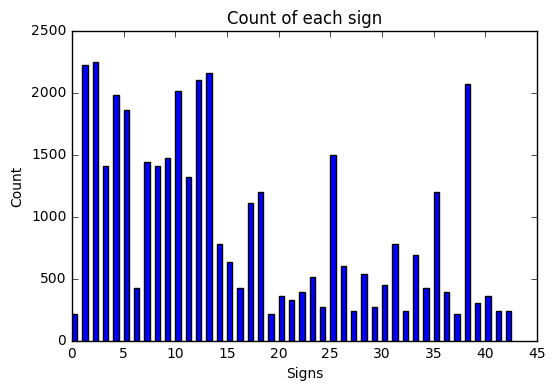

In [4]:
def plot_histogram(labels):
    """
    This function plots a histogram of the signs classes,
    and prints some useful information about the number 
    of observations per class.    
    :input labels: array with the signs labels for each feature
    """
    print()
    print("Plotting the count of each sign...")
    inputs_per_class = np.bincount(labels)
    max_inputs = np.max(inputs_per_class)
    print()
    print("    Max observations for class: {}".format(max(inputs_per_class)))
    print("    Min observations for class: {}".format(min(inputs_per_class)))
    mpl_fig = plt.figure()
    ax = mpl_fig.add_subplot(111)
    ax.set_ylabel('Count')
    ax.set_xlabel('Signs')
    ax.set_title('Count of each sign')
    ax.bar(range(len(inputs_per_class)), inputs_per_class, 0.5, color='blue')
    plt.show()
    
X_train = np.array(X_train)
y_train = np.array(y_train)
plot_histogram(y_train)

Printing a grid with one random image per class...


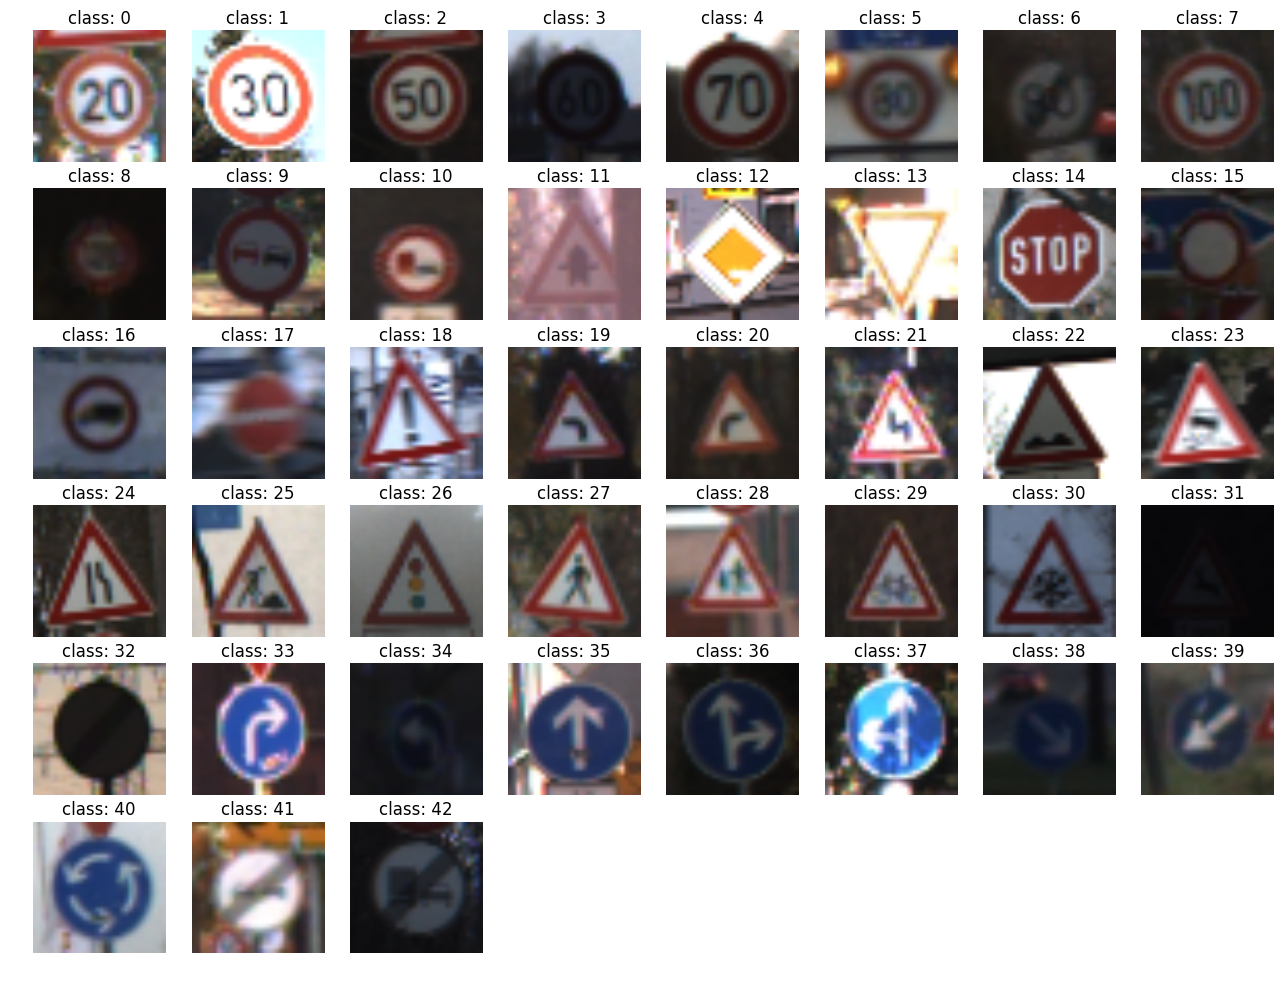

In [5]:
def plot_grid(features, labels):
    """
    This function plots a random image of each class 
    using a 8x8 grid.
    """
    print('Printing a grid with one random image per class...')
    plt.figure(figsize=(16, 16))
    for label in range(len(set(labels))):
        # find the indexes of the elements labeled as i
        mask = np.where(labels == label)[0]
        # select a random element 
        img = features[np.random.choice(mask)]
        # plot the grid
        plt.subplot(8, 8, label+1)
        plt.title('class: {}'.format(label))
        plt.imshow(img)
        plt.axis('off')

    plt.show()

plot_grid(X_train, y_train)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

- To avoid high data variance, I normalized the image data values between 0.1 and .9.
- To avoid overfitting, I shuffled the image data at the beginning

In [6]:
### Generate data additional data (OPTIONAL!)
def normalize(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    print('Normalizing features...')
    return (image_data * 0.8) / 255. + 0.1

X_train = normalize(X_train)

Normalizing features...


In [7]:
# Initial shuffle of labels and features
print("Shuffling the training data...")
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

Shuffling the training data...


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

Some classes in the training data are underrepresented, some by a 1:9 ratio compared to some others.

So for each class, I calculate a ratio to generate additional images, applying affine transform to the originals, until I had a roughly similar amount of inputs for each class.

Generating additional data...
    New features: 43798

Plotting the count of each sign...

    Max observations for class: 2250
    Min observations for class: 1200


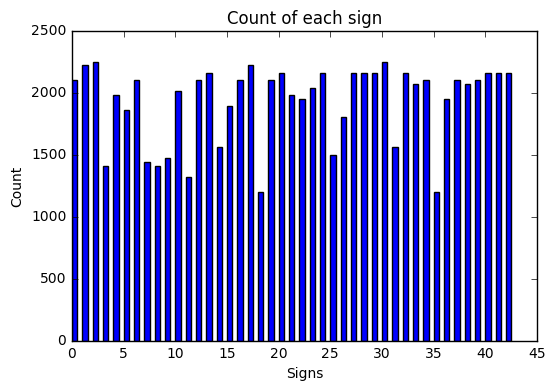

In [8]:
import cv2

# Generate additional data for underrepresented classes
def transform_image(img, ang_range, shear_range, trans_range):
    """
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    """
    
    # Rotation
    ang_rot = np.random.uniform(ang_range) - ang_range / 2
    rows, cols, ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols / 2, rows / 2), ang_rot, 1)

    # Translation
    tr_x = trans_range * np.random.uniform() - trans_range / 2
    tr_y = trans_range * np.random.uniform() - trans_range / 2
    Trans_M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])

    # Shear
    pts1 = np.float32([[5, 5], [20, 5], [5, 20]])

    pt1 = 5 + shear_range * np.random.uniform() - shear_range / 2
    pt2 = 20 + shear_range * np.random.uniform() - shear_range / 2

    pts2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])

    shear_M = cv2.getAffineTransform(pts1, pts2)
        
    img = cv2.warpAffine(img, Rot_M, (cols, rows))
    img = cv2.warpAffine(img, Trans_M, (cols, rows))
    img = cv2.warpAffine(img, shear_M, (cols, rows))
    
    return img

def data_augmentation(features, labels):
    """
    This function it creates additional data, applying affine 
    transformation to images, to balance the number of inputs 
    and reducing the probable bias the network could 
    have towards some classes.
    
    :param features: array with the current features to augment
    :param labels: array with the labels for the current features
    
    :return new_features: array with the new generated features 
    :return new_labels: array with the labels for the new features.
    """
    print('Generating additional data...')
    inputs_per_class = np.bincount(labels)
    max_inputs = np.max(inputs_per_class)

    new_features = []
    new_labels = []
    for label in range(n_classes):
        # calculate a ratio of new images to be generated
        mask = np.where(labels == label)
        class_features = features[mask]
        ratio = int(max_inputs / inputs_per_class[label]) - 1

        for j in range(ratio * len(class_features)):
            feature = class_features[np.random.randint(len(class_features))]
            new_img = transform_image(feature, 20, 10, 5)
            new_features.append(new_img)
            new_labels.append(label)
            
    print("    New features: {}".format(len(new_features)))
    return new_features, new_labels

f,l = data_augmentation(X_train, y_train)
X_train = np.append(X_train, f, axis=0)
y_train = np.append(y_train, l, axis=0)

plot_histogram(y_train)

To create the validation dataset, I split the training dataset using a proportion of 80/20, to avoid data overfitting.

In [9]:
# There isn't a validation data set, so we create slicing the training set at 80%
print("Slicing the validation set slicing from the training set...")

from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0)

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))

# update the global values
n_train = len(X_train)
n_validation = len(X_validation)

print()
print("    Training Set:      {} samples".format(n_train))
print("    Validation Set:    {} samples".format(n_validation))
print("    Test Set:          {} samples".format(n_test))


Slicing the validation set slicing from the training set...

    Training Set:      66405 samples
    Validation Set:    16602 samples
    Test Set:          12630 samples


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The used architecture is based on LeNet:

- Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x12. Pooling. Input = 28x28x12. Output = 14x14x12.
- Layer 2: Convolutional. Output = 10x10x32. Pooling. Input = 10x10x32. Output = 5x5x32. Flatten. Input = 5x5x32. Output = 800.
- Layer 3: Fully Connected. Input = 800. Output = 240.     
- Layer 4: Fully Connected. Input = 240. Output = 168.       
- Layer 5: Fully Connected. Input = 168. Output = 86. Layer 5: Fully Connected. Input = 86. Output = 43.


In [14]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x, dropout):        
    # Hyperparameters weight initialization
    mu=MU
    sigma=SIGMA
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Apply dropout
    conv1 = tf.nn.dropout(conv1, dropout)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1 = tf.nn.relu(fc1)

    # Apply dropout
    # fc1 = tf.nn.dropout(fc1, dropout)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2 = tf.nn.relu(fc2)
    
    # Apply dropout
    # fc2 = tf.nn.dropout(fc2, dropout)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I based my solution on LeNet example, using the Adam optimizer. After many tests, the learning rate of 0.001 seemed to learn fast enough without getting stuck in a local minimum.

Dropout was applied.

Trial and error was used to find a good batch and epochs size.
The final version used a batch size of #TODO and #TODO epochs.

In [11]:
# Graph input: Features and Labels 
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)  # dropout (keep probability)
one_hot_y = tf.one_hot(y, 43)

# Training Pipeline
rate = 0.001
logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

- LeNet as a base
- increasing sigma value to 0.1-0.05 and decrease the rate to 0.001
- EPOCHs 25-30
- introducing dropout after first and second CNN layer.
- TODO: extend the explanation

In [12]:
# Model Evaluation

# Evaluate how well the loss and accuracy of the model for a given dataset.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        # passing a keep_prob of 1 to evaluate the network
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [20]:
# Model Training
import time

EPOCHS = 1
BATCH_SIZE = 128
MU = 0
SIGMA = 0.05
DROPOUT = 1

with tf.Session() as sess:
    # Run the training data through the training pipeline to train the model.
    sess.run(tf.initialize_all_variables())
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        # Before each epoch, shuffle the training set.
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, n_train, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            # Run optimization op (backprop)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: DROPOUT})
        
        # After each epoch, measure the loss and accuracy of the validation set.
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

    # Save the model after training.
    saver = tf.train.Saver()
    filename = "model_{}".format(int(time.time()))
    saver.save(sess, MODELS_DIR + '/' + filename)
    print("Model saved")
    
    f = open('out.txt', 'a')
    f.write("{}: EPOCHS: {} dropout: {} mu: {:.3f} sigma: {:.3f} Validation: {:.3f} Test: {:.3f}\n".format(
        filename, EPOCHS, DROPOUT, MU, SIGMA, validation_accuracy, test_accuracy))
    f.close()

Training...

EPOCH 1 ...
Validation Accuracy = 0.539

Test Accuracy = 0.573
Model saved


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
import glob

def plot_images(images):
    """
    This function plots the local images using a 8x8 grid.
    """
    print('Printing a grid with local images...')
    plt.figure(figsize=(16, 16))
    for i,img in enumerate(images):
        # plot the grid
        plt.subplot(8, 8, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

images = [plt.imread(file).astype(np.float32) for file in glob.glob(SIGNS_DIR + "/*")]

plot_images(images)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.